# ModOAP - Classification automatique de textes (Entrainement)

Ce script permet d'entraîner et d'évaluer des modèles pour la classification automatique de de texte.

Ces modèles prennent la forme d'un dossier sur un Google Drive et peuvent ensuite être importés dans le script *ModOAP - Classification automatique de textes*.

L'entraînement nécessite des données annotées. Pour chaque type de classification, un fichier tableau différent doit être fourni au format CSV. 

Trois types de classifications possibles :

1.   Classification binaire : associer un texte à une étiquette ou 0 (une seule étiquette possible)
2.   Classification multiclass : associer un texte à une étiquette parmi un jeu d'étiquettes
3.   Classification multilabel : associer un texte à une ou plusieurs étiquettes parmi un jeu d'étiquettes

Le script implémente la bibliothèque Simple Transformers : https://simpletransformers.ai/



**Ce script doit être lancé dans un environnement d'exécution GPU : Execution -> Modifier le type d'exécution -> GPU**

In [2]:
#@markdown ### Synchronisation d'un compte Google Drive et installation des pré-requis (Nécessaire)
#@markdown Lancer la cellule et se rendre sur l'url générée par Google pour connecter un compte Drive si demandé

#@markdown Cette cellule doit redémarrer l'environnement d'exécution.
# chargement d'un google drive
import os
from google.colab import drive

if not os.path.exists("/content/drive/MyDrive/") :
  drive.mount('/content/drive/')

#Importation de SimpleTransformers
try:
  from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs

except ImportError:
  !pip install -q --no-color --upgrade transformers
  !pip install -q --no-color simpletransformers
  import os
  os.kill(os.getpid(), 9)


# Entraînement d'un modèle à la classification binaire

Format des données d'entraînement : 

Un fichier CSV contenant deux colonnes :
  - la première nommée "text" contenant à chaque ligne le texte d'un bloc de texte
  - la deuxième nommée par le nom de la classe à détecter, contenant à chaque ligne la valeur 1 si le bloc de texte est associé à la classe, et aucune valeur autrement.

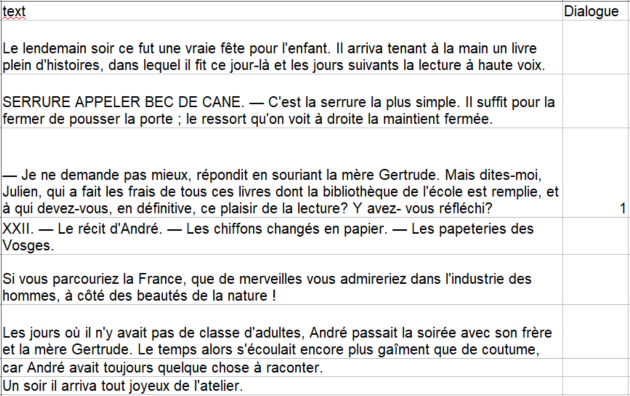




In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import os 

#@markdown ### Entraîner un modèle binaire
#@markdown Entrer le chemin du fichier CSV de blocs texte annotés pour l'entraînement :
fichier_csv = "" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/MyDrive/Outils_Modoap/Classification_Texte/Classification_blocs_texte/train.csv


#@markdown ### Spécification du dossier de destination
#@markdown Entrer le chemin du dossier où sauvegarder le modèle et les résultats :
dossier_modele = "" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/MyDrive/Outils_Modoap/Classification_Texte/Classification_blocs_texte/modele/

if not os.path.exists(dossier_modele) :
  os.makedirs(dossier_modele)

train_df = pd.read_csv(fichier_csv, sep="\t")
classe = train_df.columns[-1]

nb_txt_blocks = len(train_df[train_df.columns[0]])

print("classe à repérer : ", classe)
print(nb_txt_blocks, "blocs texte")

# Diviser en train et val

# Diviser le dataframe train en train et val
#train_df_multiclass.columns = ['text', 'labels']
print("Division du corpus Entraînement (75%) / Validation (25%)")
train_df = train_df.fillna(0)

train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df[train_df.columns[-1]], random_state=42)


#@markdown ### Nombre d'époques pour l'entraînement
#@markdown Entrer le nombre d'itérations souhaité pour l'entraînement :

nb_epoques = "5" #@param {type:"string"}
nb_epoques = int(nb_epoques)
nb_classes = 2

# Création d'un csv template pour les prédictions
colonnes = ["text", classe]
dftemp= pd.DataFrame(columns=colonnes)
fich_temp = os.path.join(dossier_modele,"dftemp.csv")
dftemp.to_csv(fich_temp, index=False, sep="\t")

## Entrainement 

print("*** Entraînement du modèle sur le corpus ***")
model_args = ClassificationArgs(num_train_epochs=nb_epoques, output_dir=dossier_modele,overwrite_output_dir=True, manual_seed=42, cache_dir=dossier_modele)
model = ClassificationModel(model_type='camembert', model_name='camembert-base', use_cuda=True, num_labels=nb_classes, args=model_args)
model.train_model(train_df)

## Evaluation

print("*** Evaluation du modèle sur le corpus ***")
result, model_outputs, wrong_preds = model.eval_model(valid_df)
predictions = []
for x in model_outputs:
    predictions.append(np.argmax(x))
print("f1 score:", f1_score(valid_df[valid_df.columns[-1]], predictions, average="weighted"))
print("evaluation loss : ", result["eval_loss"])

# Visualisation de l'évaluation 
labz = [x for x in list(valid_df[valid_df.columns[-1]])]
predictionz = [int(x) for x in predictions]
textz = [txt for txt in list(valid_df[train_df.columns[0]])]

viz = {'text': textz,
        'annot_manuelle': labz,
        'prediction': predictionz
       }
df_viz = pd.DataFrame (viz, columns = ['text','annot_manuelle', 'prediction'])

fichier_resultats = os.path.join(dossier_modele,"visualisation_evaluation.csv")
df_viz.to_csv(fichier_resultats, index = False, sep="\t")

print("Les résultats de l'évaluation ont été sauvegardés dans le fichier ", fichier_resultats)
df_viz

In [ ]:
#@markdown ### Essai du modèle sur texte libre (Facultatif)
#@markdown Entrer un texte à soumettre au classifieur :
texte = "" #@param {type:"string"}
texte = [texte]
test_predictions, raw_outputs = model.predict(texte)

if test_predictions[0] == 0 :
  print("classe associée : 0")
else :
  print("classe associée : ", classe)


# Entraînement d'un modèle à la classification multiclass 

Format des données d'entraînement :

Un fichier CSV contenant deux colonnes :

- la première nommée "text" contenant à chaque ligne le texte d'un bloc de texte
- la deuxième nommée "labels", contenant à chaque ligne le nom de la classe associée (sensible à la casse)


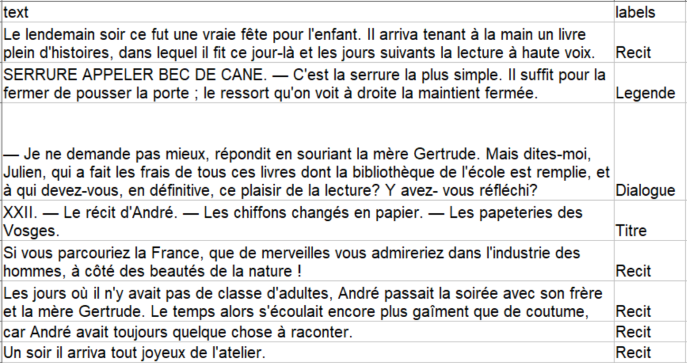


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import os
import json


def Classes2Num(classes):
  assoc_chiffres_classes = {}
  i = 0
  for classe in classes :
    assoc_chiffres_classes[str(classe)] = i
    i += 1
  return assoc_chiffres_classes

def search_assoc(num, assoc_chiffres_classes):
  for classe, numb in assoc_chiffres_classes.items():
    if num == numb :
      return classe



#@markdown ### Entraîner un modèle multiclass
#@markdown Entrer le chemin du fichier CSV de blocs texte annotés pour l'entraînement :
fichier_csv = "" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/MyDrive/Outils_Modoap/Classification_Texte/Classification_blocs_texte/train_multiclass.csv


#@markdown ### Spécification du dossier de destination
#@markdown Entrer le chemin du dossier où sauvegarder le modèle et les résultats :
dossier_modele = "" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/MyDrive/Outils_Modoap/Classification_Texte/Classification_blocs_texte/modele/
if not os.path.exists(dossier_modele) :
  os.makedirs(dossier_modele)

#@markdown ### Nombre d'époques pour l'entraînement
#@markdown Entrer le nombre d'itérations souhaité pour l'entraînement :

nb_epoques = "5" #@param {type:"string"}
nb_epoques = int(nb_epoques)



train_df = pd.read_csv(fichier_csv, sep="\t")
classes = [str(classe) for classe in set(train_df[train_df.columns[-1]])]
nb_classes = len(set(list(train_df[train_df.columns[-1]])))

assoc_chiffres_classes = Classes2Num(classes)
nb_txt_blocks = len(train_df[train_df.columns[0]])
print(len(classes),"classes reconnues : ", classes)
print(nb_txt_blocks, "blocs texte")

# Transformer les noms d'étiquettes en chiffres

train_df2 = {'text': train_df[train_df.columns[0]],
        'labels': [assoc_chiffres_classes[str(classe)] for classe in train_df[train_df.columns[-1]]]
            }
train_df_multiclass = pd.DataFrame (train_df2, columns = ['text','labels'])

# Création d'un json pour sauvegarder l'association classes/chiffres
fich_temp = os.path.join(dossier_modele,"class_temp.json")
with open(fich_temp, 'w') as outfile:
    json.dump(assoc_chiffres_classes, outfile)

# Diviser le dataframe train en train et val
print("Division du corpus Entraînement (75%) / Validation (25%)")
train_df, valid_df = train_test_split(train_df_multiclass, test_size=0.2, stratify=train_df_multiclass['labels'], random_state=42)


# Création d'un csv template pour les prédictions
colonnes = ["text"] + classes
dftemp= pd.DataFrame(columns=colonnes)
fich_temp = os.path.join(dossier_modele,"dftemp.csv")
dftemp.to_csv(fich_temp, index=False, sep="\t")

## Entrainement 

print("*** Entraînement du modèle sur le corpus ***")
model_args = ClassificationArgs(num_train_epochs=nb_epoques, output_dir=dossier_modele,overwrite_output_dir=True, manual_seed=42, cache_dir=dossier_modele)
model = ClassificationModel(model_type='camembert', model_name='camembert-base', use_cuda=True, num_labels=nb_classes, args=model_args)
model.train_model(train_df)

## Evaluation

print("*** Evaluation du modèle sur le corpus ***")
result, model_outputs, wrong_preds = model.eval_model(valid_df)
predictions = []
for x in model_outputs:
    predictions.append(np.argmax(x))
print("f1 score:", f1_score(valid_df["labels"], predictions, average="weighted"))
print("evaluation loss : ", result["eval_loss"])

# Visualisation de l'évaluation 
labz = [search_assoc(x,assoc_chiffres_classes) for x in list(valid_df["labels"])]
predictionz = [search_assoc(x,assoc_chiffres_classes) for x in predictions]
textz = [txt for txt in list(valid_df["text"])]

viz = {'text': textz,
        'annot_manuelle': labz,
        'prediction': predictionz
       }
df_viz = pd.DataFrame (viz, columns = ['text','annot_manuelle', 'prediction'])

fichier_resultats = os.path.join(dossier_modele,"visualisation_evaluation.csv")
df_viz.to_csv(fichier_resultats, index = False, sep="\t")

print("Les résultats de l'évaluation ont été sauvegardés dans le fichier ", fichier_resultats)
df_viz

In [ ]:
#@markdown ### Essai du modèle sur texte libre (Facultatif)
#@markdown Entrer un texte à soumettre au classifieur :
texte = "" #@param {type:"string"}
texte = [texte]
test_predictions, raw_outputs = model.predict(texte)
print("Classe associée : ", search_assoc(test_predictions[0], assoc_chiffres_classes))


# Entraînement d'un modèle à la classification multilabel

Format des données d'entraînement :

Un fichier CSV contenant au moins trois colonnes :

- la première nommée "text" contenant à chaque ligne le texte d'un bloc de texte
- les suivantes nommées par chacun des noms des étiquettes du jeu, contenant à chaque ligne la valeur 1 si la l'étiquette est associée au texte, laisser vide autrement

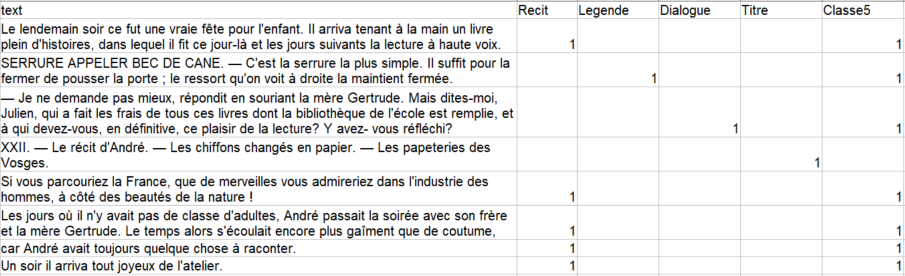


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


#@markdown ### Entraîner un modèle multilabel
#@markdown Entrer le chemin du fichier CSV de blocs texte annotés pour l'entraînement :
fichier_csv = "" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/MyDrive/Outils_Modoap/Classification_Texte/Classification_blocs_texte/train_multilabel.csv



#@markdown ### Spécification du dossier de destination
#@markdown Entrer le chemin du dossier où sauvegarder le modèle et les résultats :
dossier_modele = "" #@param {type:"string"}
#@markdown Exemple de chemin:
#@markdown /content/drive/MyDrive/Outils_Modoap/Classification_Texte/Classification_blocs_texte/modele/
if not os.path.exists(dossier_modele) :
  os.makedirs(dossier_modele)

#@markdown ### Nombre d'époques pour l'entraînement
#@markdown Entrer le nombre d'itérations souhaité pour l'entraînement :

nb_epoques = "5" #@param {type:"string"}
nb_epoques = int(nb_epoques)

df = pd.read_csv(fichier_csv,sep='\t')

df = df.fillna(0)

# Transformer les colonnes classes en 1 colonne liste de résultats
list_labels = []
df_list = df.values.tolist()
for element in df_list :
  list_labels.append(element[1:])
for list_results in list_labels :
  for n, i in enumerate(list_results) :
    if int(i) == 1 :
      list_results[n] = 1
    else :
      list_results[n] = 0
for i in range(len(list_labels)) :
  list_labels[i] = np.array(list_labels[i])
df_train = pd.DataFrame (df, columns = ['text','labels'])
df_train["labels"] = list_labels

classes = list(df.columns[1:])
nb_classes = len(classes)

print(len(classes),"classes reconnues : ", classes)
print(nb_txt_blocks, "blocs texte")

# Diviser le dataframe train en train et val
print("Division du corpus Entraînement (75%) / Validation (25%)")
train_df, valid_df = train_test_split(df_train, test_size=0.2, random_state=42)

# Entrainement 
print("*** Entraînement du modèle sur le corpus annoté ***")
model_args = MultiLabelClassificationArgs(num_train_epochs=nb_epoques, overwrite_output_dir=True, cache_dir=dossier_modele)
# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel("camembert", "camembert-base", args=model_args, num_labels=nb_classes)
model.train_model(train_df, multi_label=True, output_dir=dossier_modele)

# Evaluation
print("** Evaluation du modèle sur le corpus annoté **")
result, model_outputs, wrong_preds = model.eval_model(valid_df)
lrap = result["LRAP"]
loss = result["eval_loss"]

print("Label Ranking Average Precision : ", lrap)
print("Loss : ", loss)

# Création d'un csv template pour les prédictions
colonnes = ["text"] + classes
dftemp= pd.DataFrame(columns=colonnes)
fich_temp = os.path.join(dossier_modele,"dftemp.csv")
dftemp.to_csv(fich_temp, index=False, sep="\t")




In [ ]:
#@markdown ### Essai du modèle sur texte libre (Facultatif)
#@markdown Entrer un texte à soumettre au classifieur :
texte = "" #@param {type:"string"}
texte = [texte]
test_predictions, raw_outputs = model.predict(texte)
print("Classes associées : ")
for e in test_predictions[0] :
  print(classes[e])
